In [2]:
import xml.etree.ElementTree as ET
import os
import os.path 
import pandas as pd
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
import mne
import braindecode

In [3]:
# FUNCTIONS

def get_sig(fname, ch):
    
    '''
    Returns signal of the desired channel ch in BDF file fname
    '''
    
    with pyedflib.EdfReader(fname) as f: 
        
        file_dur=f.getFileDuration()

        header=f.getSignalHeader(ch)
        print(header['label'])
        sig=f.readSignal(ch)
    
    return sig



import subprocess

def find_files(file_name):
    
    '''
    Ubuntu: finds the indicated file and returns a list of all 
    subdirectories that contain file of name file_name
    '''
    
    command = ['locate', file_name]

    output = subprocess.Popen(command, stdout=subprocess.PIPE).communicate()[0]
    output = output.decode()

    search_results = output.split('\n')

    return search_results


# Experiment-specific functions

def map2arsl(feltEmo): 
    
    '''
    map the feltEmo to level of arousal: 0 - calm, 1 - medium arousal, 2 - excited/activated
    '''
    if feltEmo == None: 
        arslclass = None
        
    else: 
        feltEmo = int(feltEmo)
        
        if feltEmo == 0 or feltEmo == 5 or feltEmo == 2:  
            arslclass = int(0)

        elif feltEmo == 4 or feltEmo == 11: 
            arslclass = int(1)

        elif feltEmo == 6 or feltEmo == 3 or feltEmo == 1 or feltEmo == 12: 
            arslclass = int(2)

        else: 
            arslclass = None
    
    return arslclass


def map2vlnc(feltEmo): 
    
    '''
    map the feltEmo to level of valence: 1 - unpleasant, 2 - neutral valence, 3 - pleasant
    '''
    if feltEmo == None:
        vlncclass = None
        
    else: 
        feltEmo = int(feltEmo)
        
        if feltEmo == 3 or feltEmo == 1 or feltEmo == 2 or feltEmo == 5 or feltEmo == 12:  
            vlncclass = int(0)

        elif feltEmo == 6 or feltEmo == 0: 
            vlncclass = int(1)

        elif feltEmo == 4 or feltEmo == 11: 
            vlncclass = int(2)
        
        else: 
            vlncclass = None
    
    return vlncclass
    

In [4]:
### Read in XML/Experiment information

rootdir = "/home/hader/Documents/EEG_Datasets_Emotion/HCI/Sessions" # Directory with all subfolders of experiment

# Create a list to store information on experiments
info_list = []

# Look for all xml files
for dirpath, dirnames, filenames in os.walk(rootdir):
    
    for filenamexml in [f for f in filenames if f.endswith("session.xml")]: 
        
        filepath = os.path.join(dirpath, filenamexml)

        with open(filepath, "rt") as file: # parse xml file
            file_string = file.read()
            tree = ET.fromstring(file_string)
            
            
            sessionID = tree.get('sessionId') # extract available information from xml tree
            experimentType = tree.get('experimentType')
            isStim = tree.get('isStim')
            feltEmo = tree.get('feltEmo')
            feltArsl = tree.get('feltArsl')
            feltVlnc = tree.get('feltVlnc') 
            feltCtrl= tree.get('feltCtrl') 
            feltPred= tree.get('feltPred') 
            cutNr= tree.get('cutNr') 
            cutLenSec= tree.get('cutLenSec') 
    
            subject = tree.findall('./subject')
            subjectID = subject[0].get('id')
            
            # Find name of corresponding BDF file
            tracks = tree.findall('./track')
            for track in tracks: 
                if track.get('type') == 'Physiological':
                    bdf_filename_from_xml = track.get('filename')
            
                    
            dict1 = {}
            dict1['sessionID'] =  sessionID
            dict1['subjectID'] = subjectID
            dict1['experimentType'] = experimentType
            dict1['EEGFile according to xml'] = bdf_filename_from_xml
            dict1['isStim'] = int(isStim)
            dict1['path'] = dirpath[-20:]
            dict1['feltEmo'] = feltEmo
            dict1['feltArsl'] = feltArsl
            dict1['feltVlnc'] = feltVlnc
            dict1['feltCtrl'] = feltCtrl
            dict1['feltPred'] = feltPred
            dict1['cutNr'] = int(cutNr)
            dict1['cutLenSec'] = float(cutLenSec)

            info_list.append(dict1)


# Create dataframe out of info_list
df = pd.DataFrame(info_list)   
         

In [5]:
# map numbers in feltEmo to emotion
mapEmo = {0:'neutral', 1:'anger', 2:'disgust', 3:'fear', 4: 'joy, happiness', 5:'sadness', 
          6:'surprise', 7:'scream', 8:'bored', 9:'sleepy', 10:'unknown', 11:'amusement', 12:'anxiety'}

# add column to dataframe with arousal level according to feltEmo
arslList= [map2arsl(emo) for emo in df['feltEmo']]
df['arslLevel'] = arslList

# add column to dataframe with valence level according to feltEmo 
vlncList = [map2vlnc(emo) for emo in df['feltEmo']]
df['vlnceList'] = vlncList


In [7]:
print('Number of stimulated trials: ' + str(np.sum(df['isStim'])) + '\n')
print('Number of trials with emotion recorded: ' + str(np.sum(df['feltEmo'].value_counts())) + '\n')
print('Overview of emotion frequency: \n' + str(df['feltEmo'].value_counts()) + '\n')
#print('Overview of subjects and corresponding no. of trials: \n' + str(df['subjectID'].value_counts()))

Number of stimulated trials: 332

Number of trials with emotion recorded: 294

Overview of emotion frequency: 
4     56
0     49
11    43
2     39
5     35
3     23
12    23
6     16
1     10
Name: feltEmo, dtype: int64



In [57]:
ch30 = get_sig('/home/hader/Documents/EEG_Datasets_Emotion/HCI/Sessions/3/Part_1_N_Trial2_emotion.bdf', 30)

PO4


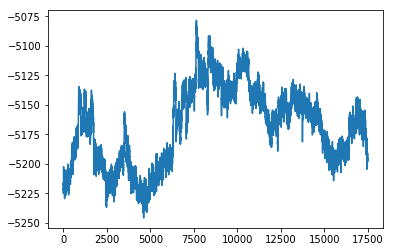

In [58]:
plt.plot(ch30[:17500])
plt.show()

In [ ]:
find_files('Part_10_N_Trial15_emotion.bdf')

In [10]:
            #for File in os.listdir(dirpath):
             #   if File.endswith(".bdf"):
              #      EEGFile = File
               #     count_bdf += 1
                #else:
                 #   EEGFile = 'None'